In [1]:
# hedfpy package didn't work because of way I'm defining blocks
# so let's try another package

In [2]:
import sys, os

# append Pygaz analyser folder, cloned from https://github.com/esdalmaijer/PyGazeAnalyser.git
sys.path.append(os.getcwd()+'/PyGazeAnalyser/')
import pygazeanalyser
import numpy as np

import pandas as pd
import glob

import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# paths
base_dir = os.getcwd()
output_vs = base_dir+'/output_VS'
output_crwd = base_dir+'/output_crowding'

In [4]:
# params
sj = '01'
vRes = 1050
hRes = 1680

In [5]:
# functions

# convert edf file to asc file
def convert2asc(sj,taskname,outVS,outCRWD):
    
    import os, glob, shutil
    from pygazeanalyser.edfreader import read_edf
    
    if type(sj) == int: #if sub num integer
        sj = str(sj).zfill(2) #turn to string
    
    #list of absolute paths to all edf files in that session for that subject
    #single hdf5 file that contains all eye data for the runs of that session
    if taskname=='vs':
        edf_file = glob.glob(os.path.join(outVS, 'eyedata_visualsearch_pp_%s.edf' %sj))[0]
        asc_dir = outVS+'/pp-{sj}/'.format(sj=sj)
    elif taskname=='crowding':
        edf_file = glob.glob(os.path.join(outCRWD, 'eyedata_crowding_pp_%s.edf' %sj))[0]
        asc_dir = outCRWD+'/pp-{sj}/'.format(sj=sj)
           
    if not os.path.exists(asc_dir): # check if path to save hdf5 files exists
        os.makedirs(asc_dir)     # if not create it
    
    os.system("edf2asc %s" % edf_file)
    
    asc_file = os.path.split(edf_file)[1].replace('.edf','.asc')
    shutil.move(os.path.join(os.path.split(edf_file)[0],asc_file),asc_dir+asc_file)
    
    asc_filename = asc_dir+asc_file
    edfdata = read_edf(asc_filename, 'start_trial', stop='stop_trial', debug=False)
    
    return asc_filename, edfdata #name of asccii, actual gaze data

# turn visual angle in degrees
def ang2pix(dist_in_deg,h,d,r): 
    import math 
    
    deg_per_px = math.degrees(math.atan2(0.5*h,d))/(0.5*r)
    dist_in_px = dist_in_deg/deg_per_px
    return dist_in_px 

# function to draw all gaze points in trial on top of display
def draw_rawdata_display(sj,trial,filename,target,distr,gazedata,hRes,vRes,radius):
        
    import matplotlib.pyplot as plt
    COLS ={"aluminium": ['#eeeeec',
                    '#d3d7cf',
                    '#babdb6',
                    '#888a85',
                    '#555753',
                    '#2e3436'],
            }

    # set figure and main axis
    fig, ax = plt.subplots()
    # change default range 
    ax.set_xlim((0, hRes))
    ax.set_ylim((0, vRes))
    
    # add target as red circle
    trg_circle = plt.Circle((target[0], target[1]), radius, color='r')
    ax.add_artist(trg_circle)

    # add distractors as blue circles
    for i in range(len(distr)):
        distr_circle = plt.Circle((distr[i][0], distr[i][1]), radius, color='b')
        ax.add_artist(distr_circle)

    # add new axis that can be inverted, for gaze data
    # invert y axis, as (0,0) is top left on a display
    ax1 = ax.twinx()
    ax1.set_xlim((0, hRes))
    ax1.set_ylim((0, vRes))
    ax1.invert_yaxis()
    ax1.get_yaxis().set_visible(False) #but don't show it
    ax1.get_xaxis().set_visible(False)

    # plot raw data points
    x = gaze[0]
    y = gaze[1] # did this to invert y axis, as (0,0) is top left on a display (#ax.invert_yaxis() will do whole thing, dont want that)

    ax1.plot(gazedata[0], gazedata[1], 'o', color=COLS['aluminium'][0], markeredgecolor=COLS['aluminium'][5])

    plt.show()
    fig.savefig(os.path.join(os.path.split(filename)[0], "rawdata_pp-%s_trial-%s.png" % (sj,str(trial).zfill(3))), dpi=1000)

    
# function to draw fixation locations and saccade path in trial on top of display   
def draw_scanpath_display(sj,trial,filename,target,distr,fixation,saccades,hRes,vRes,radius):
    
    import matplotlib.pyplot as plt
    COLS ={"aluminium": ['#eeeeec',
                    '#d3d7cf',
                    '#babdb6',
                    '#888a85',
                    '#555753',
                    '#2e3436'],
            "chameleon": ['#8ae234',
                '#73d216',
                '#4e9a06']
            }
    
    # set figure and main axis
    fig, ax = plt.subplots()
    # change default range 
    ax.set_xlim((0, hRes))
    ax.set_ylim((0, vRes))
    
    # add target as red circle
    trg_circle = plt.Circle((target[0], target[1]), radius, color='r')
    ax.add_artist(trg_circle)

    # add distractors as blue circles
    for i in range(len(distr)):
        distr_circle = plt.Circle((distr[i][0], distr[i][1]), radius, color='b')
        ax.add_artist(distr_circle)


    # ADD DISPLAY
    # add new axis with different orientation of gaze data
    ax1 = ax.twinx()
    ax1.set_xlim((0, hRes))
    ax1.set_ylim((0, vRes))
    ax1.get_yaxis().set_visible(False) #but don't show it
    ax1.get_xaxis().set_visible(False)
    # invert the y axis, as (0,0) is top left on a display
    ax1.invert_yaxis()

    alpha = 0.5 # alpha level for scanpath drawings
    
    # FIXATIONS
    # parse fixations
    from pygazeanalyser.gazeplotter import parse_fixations
    fix = parse_fixations(fixations)
    # draw fixations, size of dot depends on duration
    ax1.scatter(fix['x'],fix['y'], s=fix['dur'], c=COLS['chameleon'][2], marker='o', cmap='jet', alpha=alpha, edgecolors='none')
    # draw annotations (fixation numbers)
    for i in range(len(fixations)):
        ax1.annotate(str(i+1), (fix['x'][i],fix['y'][i]), color=COLS['aluminium'][5], alpha=1, horizontalalignment='center', verticalalignment='center', multialignment='center')

    # SACCADES
    if saccades:
        # loop through all saccades
        for st, et, dur, sx, sy, ex, ey in saccades:
            # draw an arrow between every saccade start and ending
            ax1.arrow(sx, sy, ex-sx, ey-sy, alpha=alpha, fc=COLS['aluminium'][0], ec=COLS['aluminium'][5], fill=True, shape='full', width=10, head_width=20, head_starts_at_zero=False, overhang=0)

    fig.savefig(os.path.join(os.path.split(filename)[0], "scanpath_pp-%s_trial-%s.png" % (sj,str(trial).zfill(3))), dpi=1000)

In [6]:
##define display grid, lesser resolution to not kill memory
#x_pixels, y_pixels = np.meshgrid(np.arange(0,hRes,16),np.arange(0,vRes,16)) #define grid of positions for display
#pixel_coordinates = np.array([x_pixels, y_pixels]).reshape((2,-1)) #pixel coordinates reshaped to have 2 dim, -1 is because we don't know the size of that dim

## gaze data (x,y) for that trial
#gaze = np.array([edfdata[trial]['x'],edfdata[trial]['y']])

## calculate gaze density (kernel density estimate on the data)
#from scipy.stats import gaussian_kde
#gaze_kde = gaussian_kde(gaze)
#density = gaze_kde.evaluate(pixel_coordinates)

In [7]:
# load behavioural data to get target positions
df_name = glob.glob(os.path.join(output_vs, 'data_visualsearch_pp_%s.csv' %sj))[0]
behv_data = pd.read_csv(df_name,sep='\t')


In [8]:
# get eyetracking data
filename,edfdata = convert2asc(sj,'vs',output_vs,output_crwd)

deviation from center is -4.20 pixels


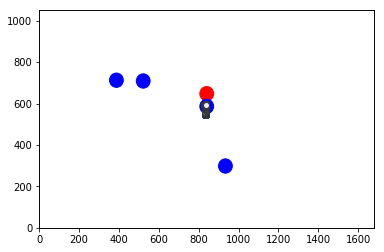

deviation from center is 11.20 pixels


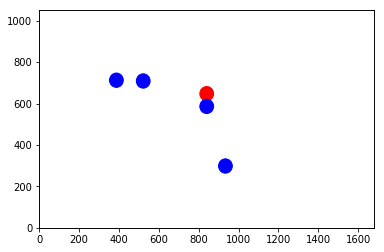

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


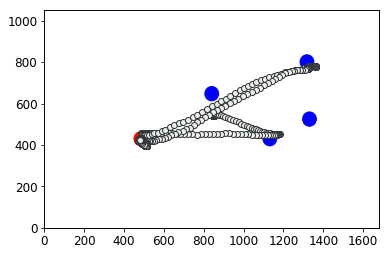

deviation from center is -6.40 pixels


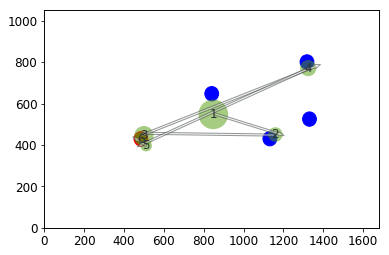

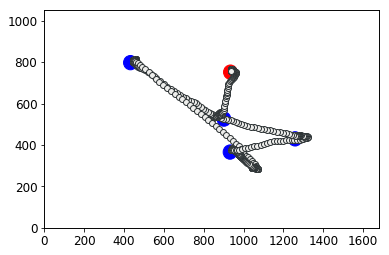

deviation from center is -4.60 pixels


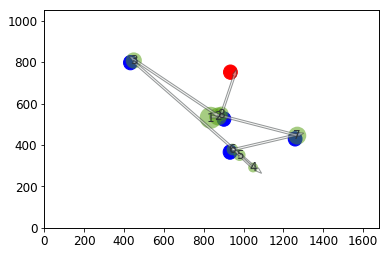

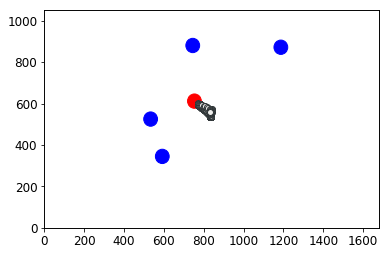

deviation from center is -4.00 pixels


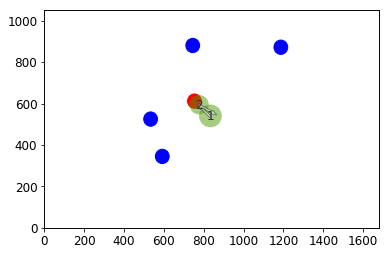

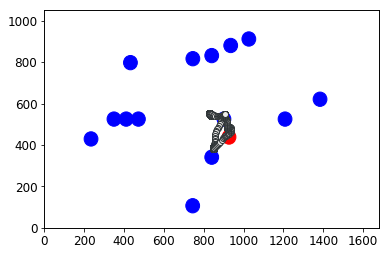

deviation from center is 0.70 pixels


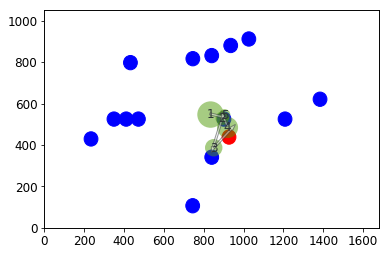

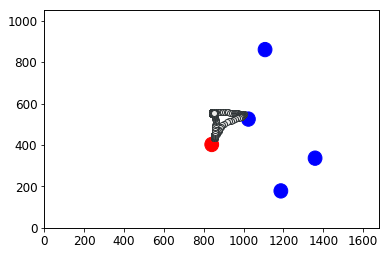

deviation from center is 8.40 pixels


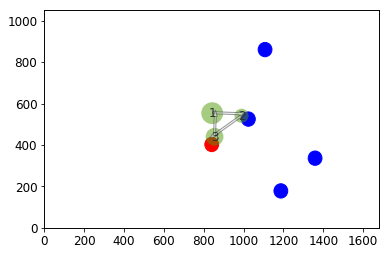

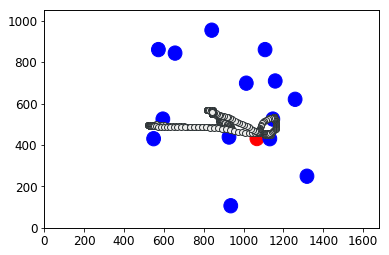

deviation from center is -7.50 pixels


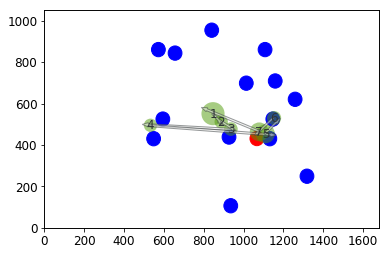

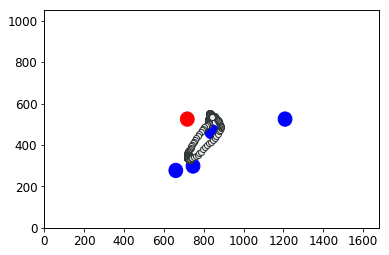

deviation from center is 3.90 pixels


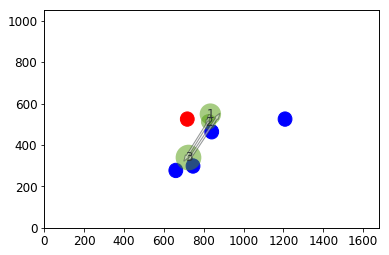

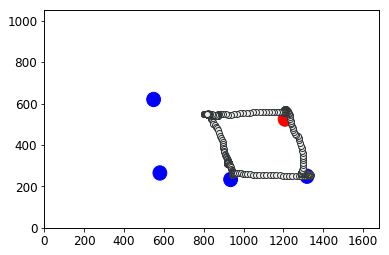

deviation from center is -9.30 pixels


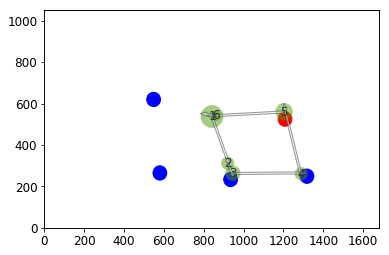

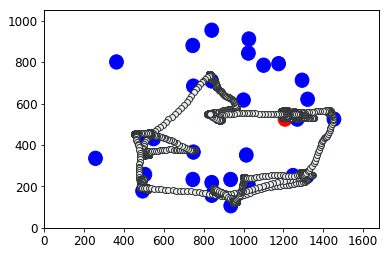

deviation from center is -5.30 pixels


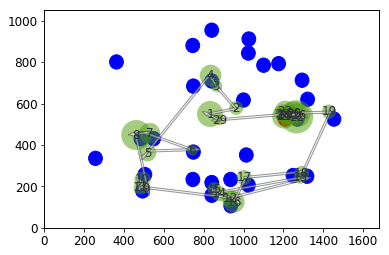

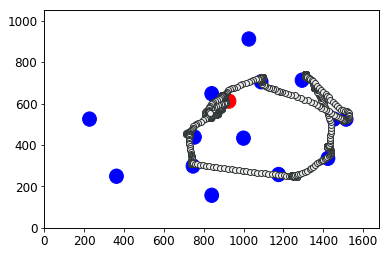

deviation from center is -16.60 pixels


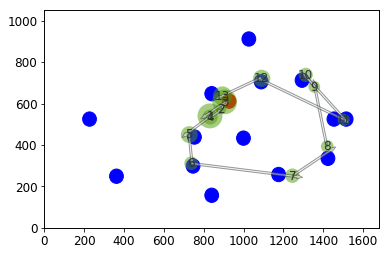

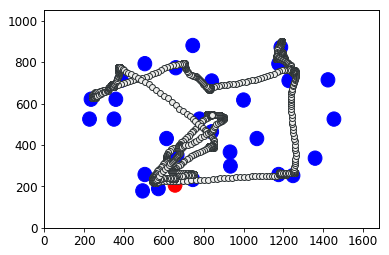

deviation from center is -14.70 pixels


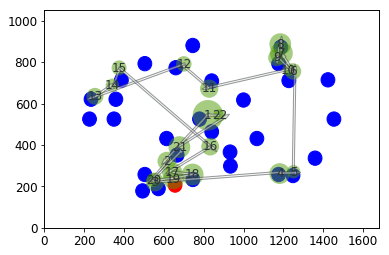

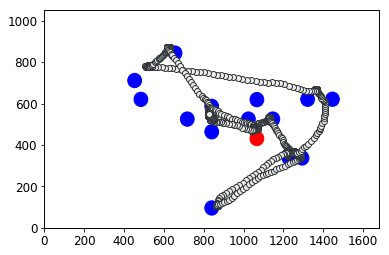

deviation from center is -11.70 pixels


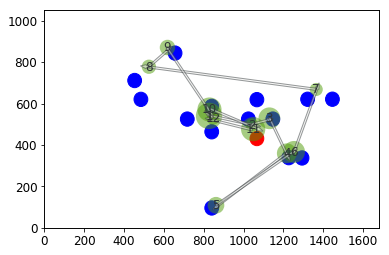

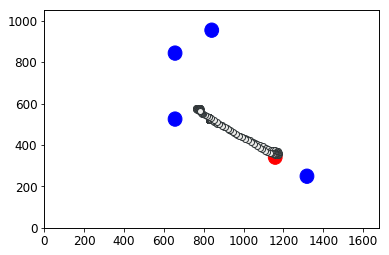

deviation from center is -19.00 pixels


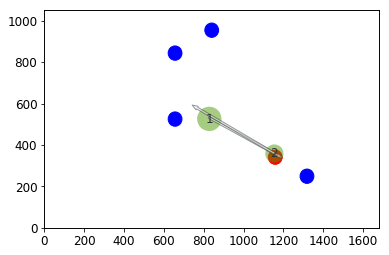

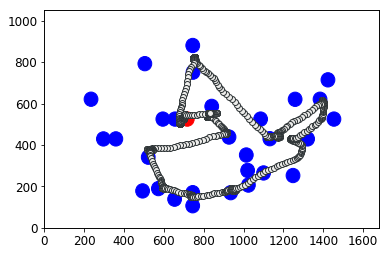

deviation from center is -9.90 pixels


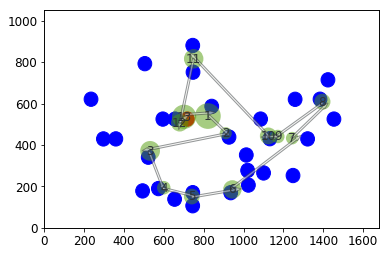

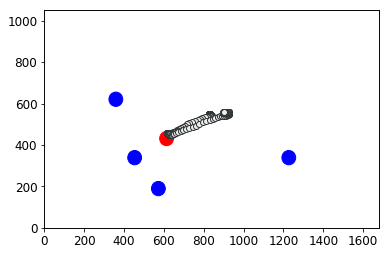

deviation from center is 4.10 pixels


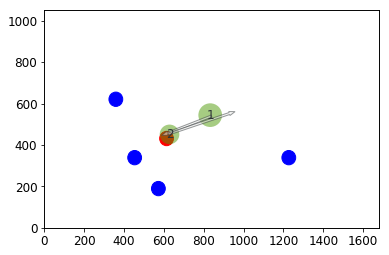

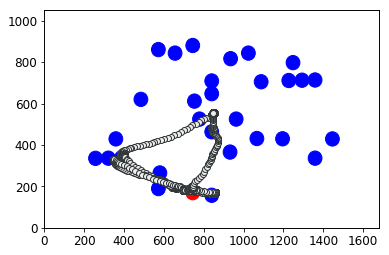

deviation from center is 12.70 pixels


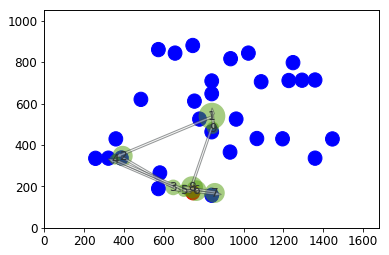

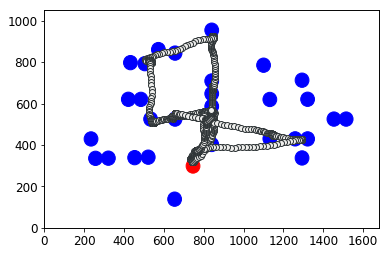

deviation from center is -10.80 pixels


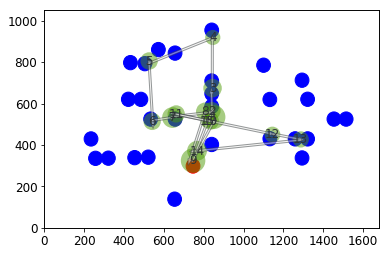

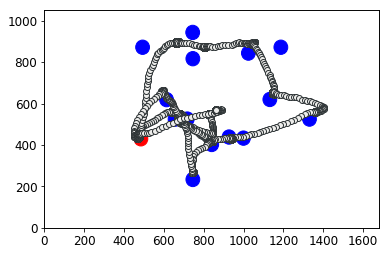

deviation from center is -4.10 pixels


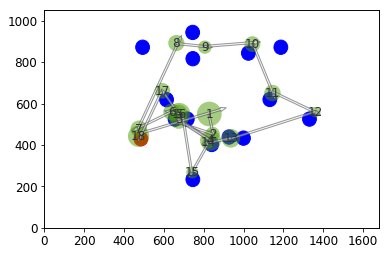

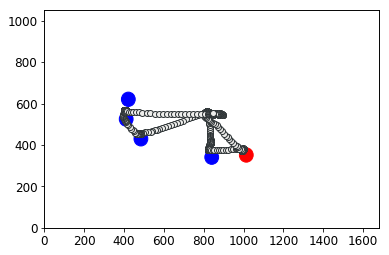

deviation from center is 0.00 pixels


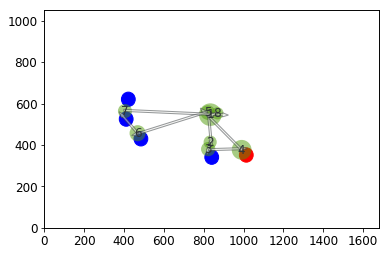

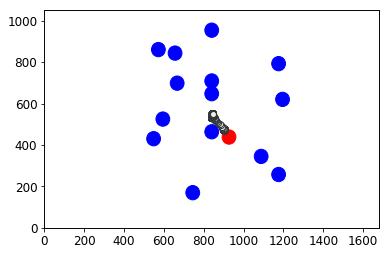

deviation from center is 3.90 pixels


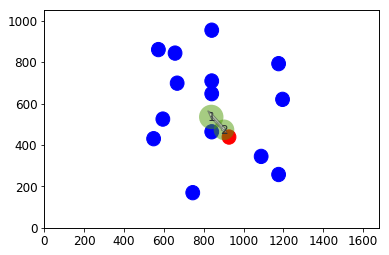

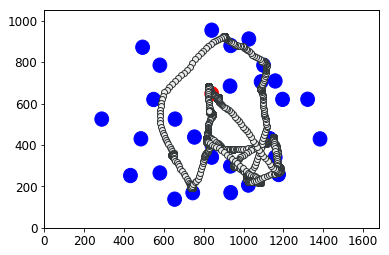

deviation from center is -13.70 pixels


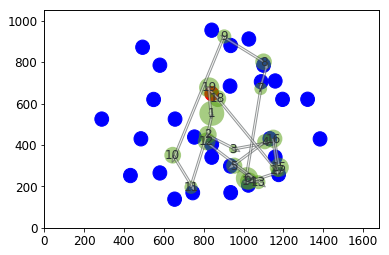

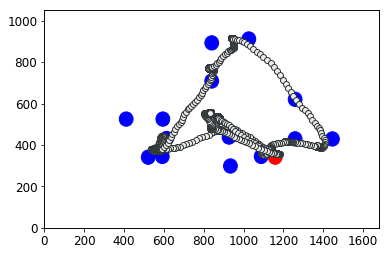

deviation from center is -6.70 pixels


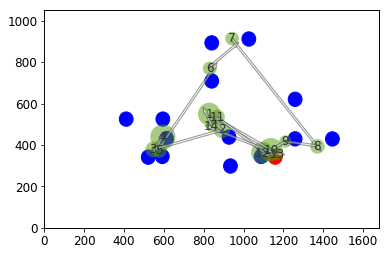

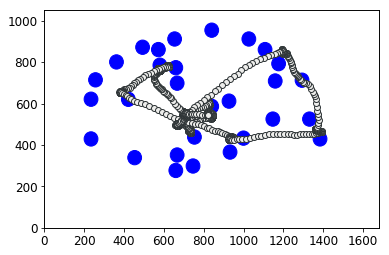

deviation from center is -14.90 pixels


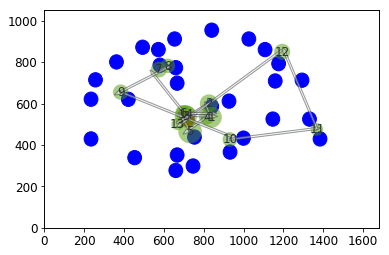

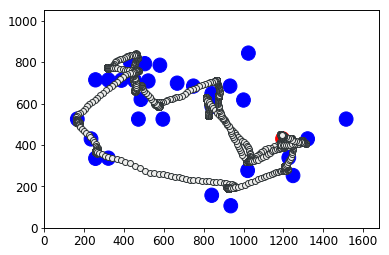

deviation from center is -9.60 pixels


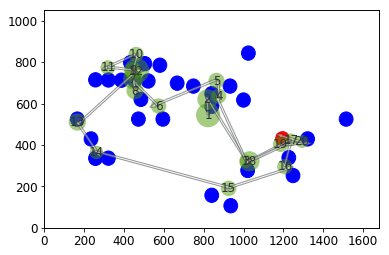

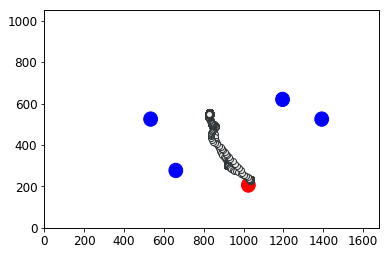

deviation from center is -11.80 pixels


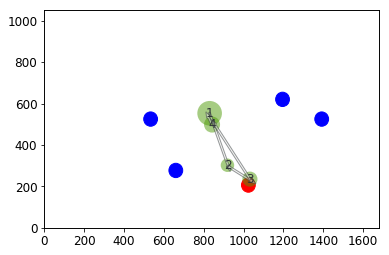

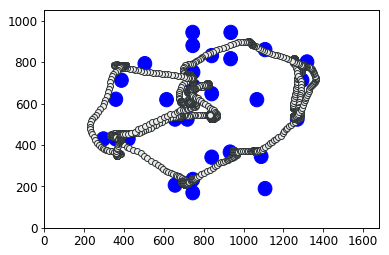

deviation from center is -3.20 pixels


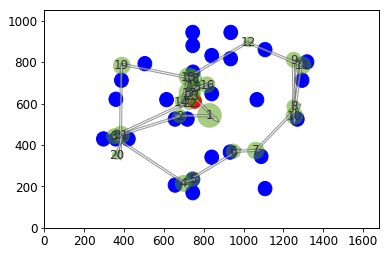

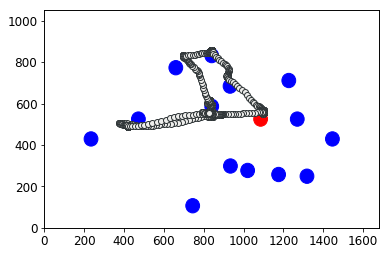

deviation from center is -14.90 pixels


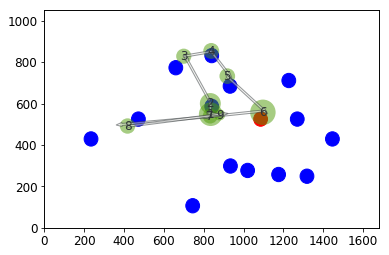

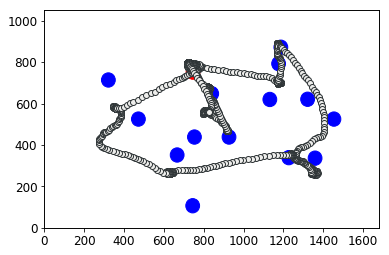

deviation from center is -20.60 pixels


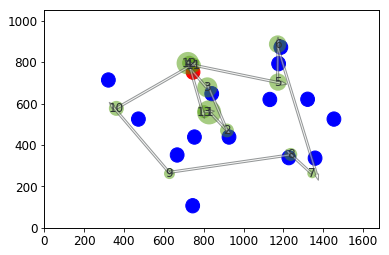

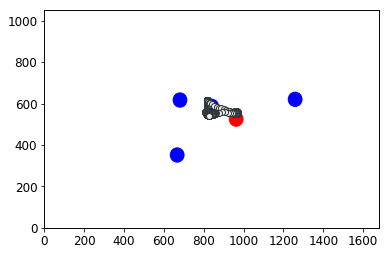

deviation from center is -22.00 pixels


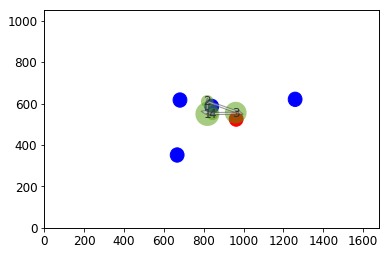

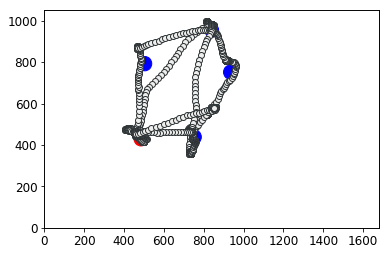

deviation from center is -31.60 pixels


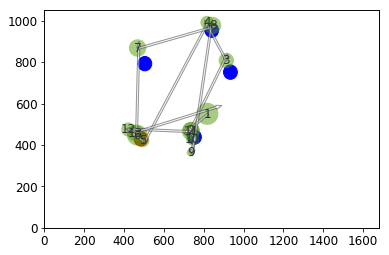

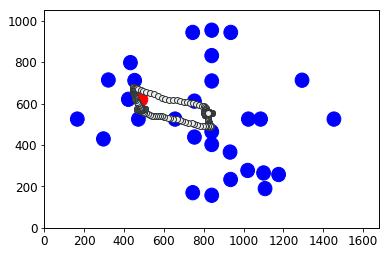

deviation from center is -7.30 pixels


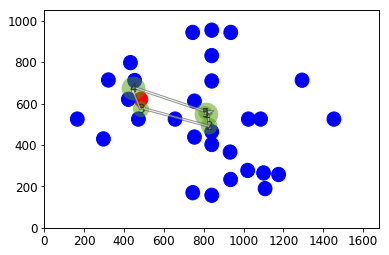

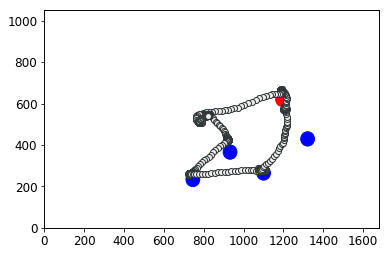

deviation from center is -18.40 pixels


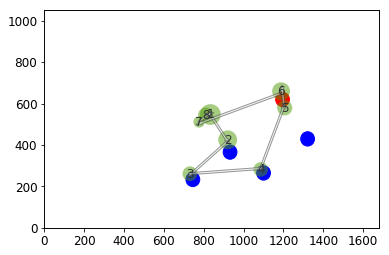

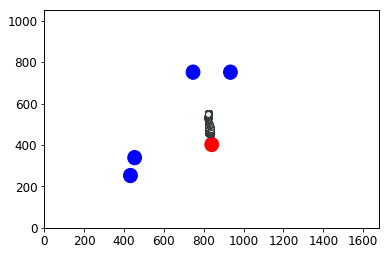

deviation from center is -21.80 pixels


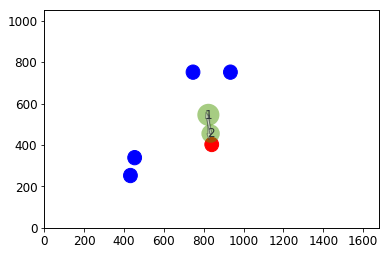

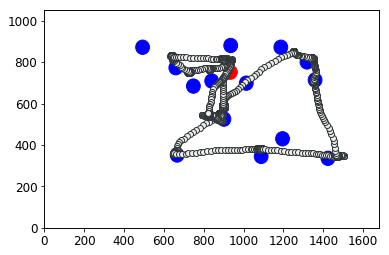

deviation from center is -7.90 pixels


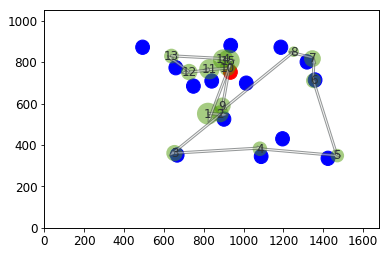

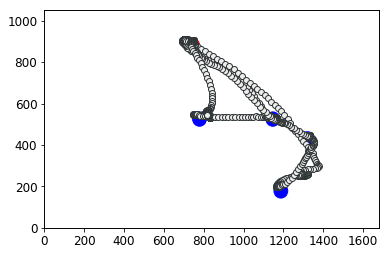

deviation from center is -16.70 pixels


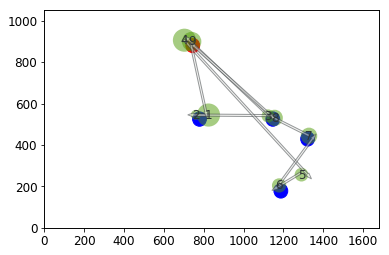

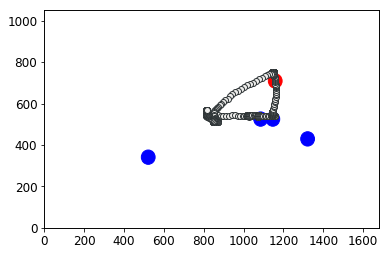

deviation from center is -21.40 pixels


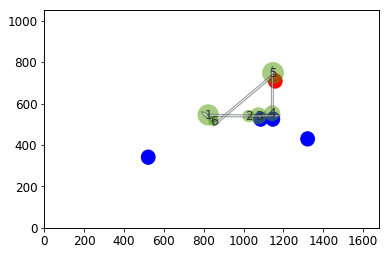

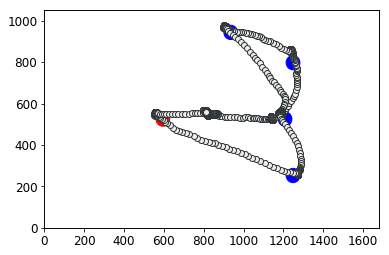

deviation from center is -16.70 pixels


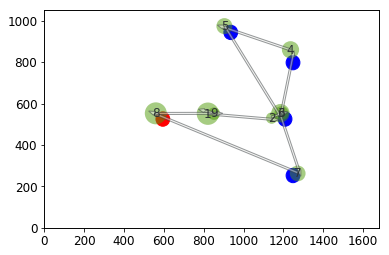

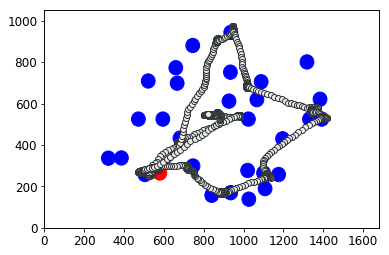

deviation from center is -23.40 pixels


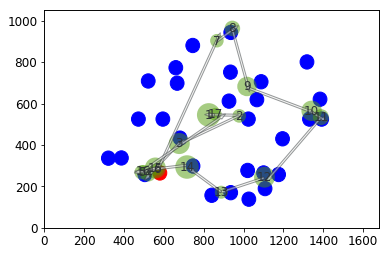

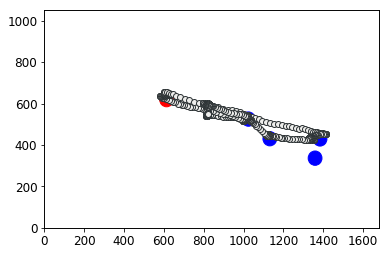

deviation from center is -20.10 pixels


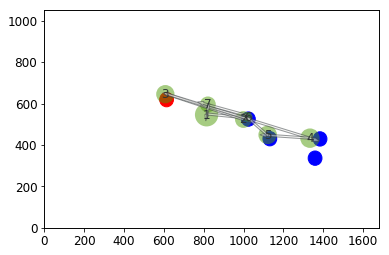

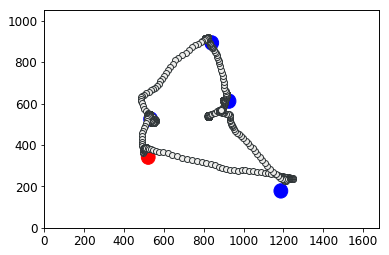

deviation from center is -2.10 pixels


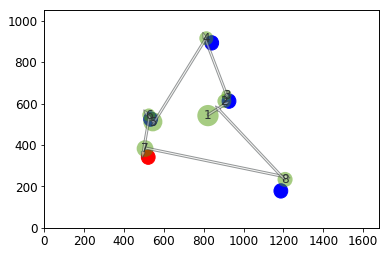

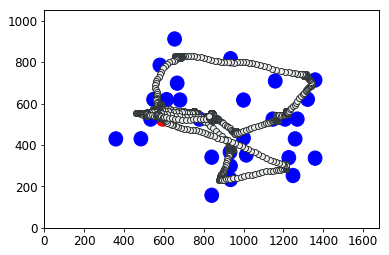

deviation from center is -11.30 pixels


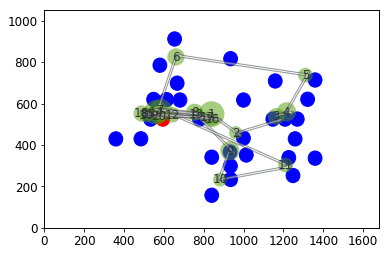

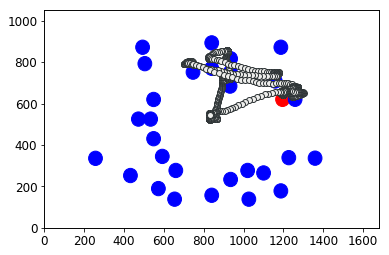

deviation from center is -2.70 pixels


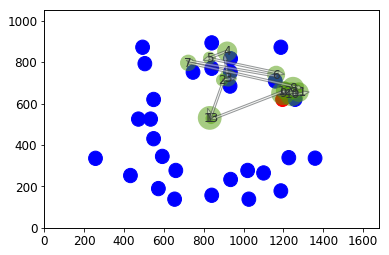

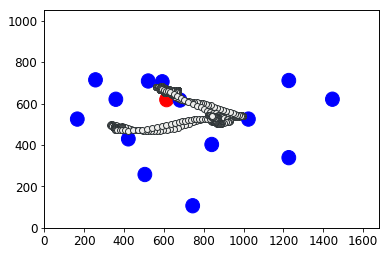

deviation from center is -1.40 pixels


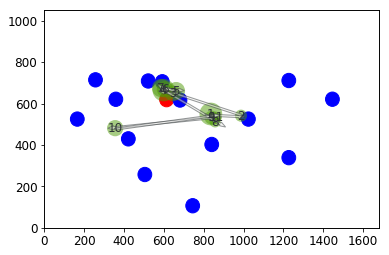

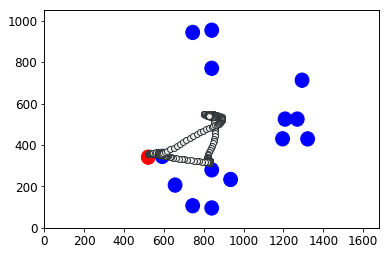

deviation from center is -10.80 pixels


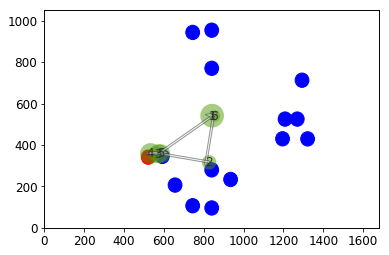

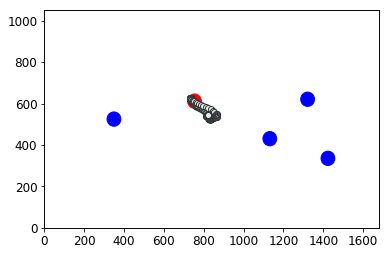

deviation from center is -15.50 pixels


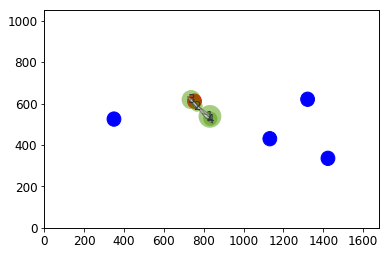

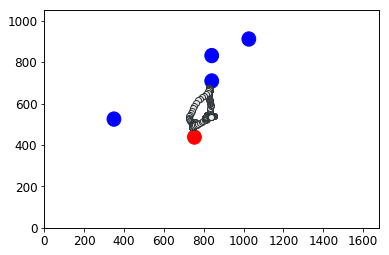

deviation from center is -1.80 pixels


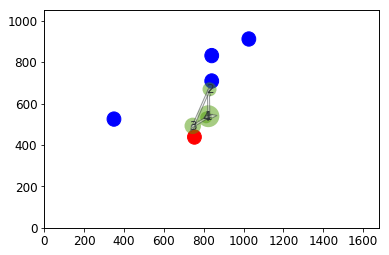

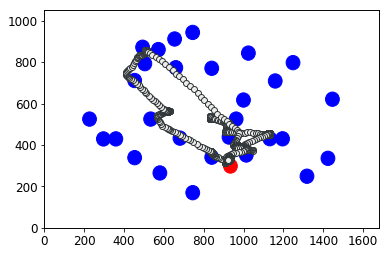

deviation from center is -13.50 pixels


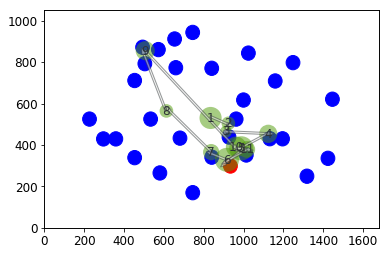

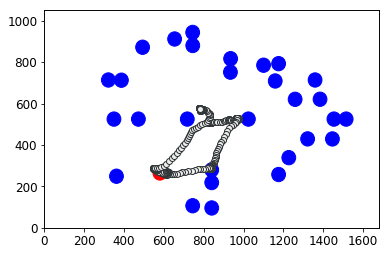

deviation from center is -27.30 pixels


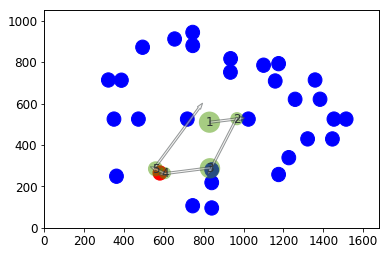

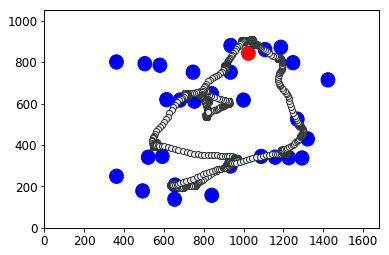

deviation from center is -20.50 pixels


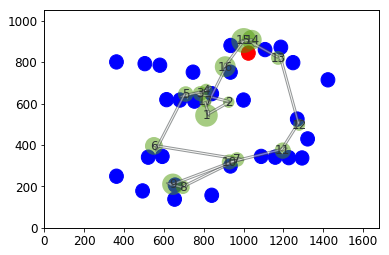

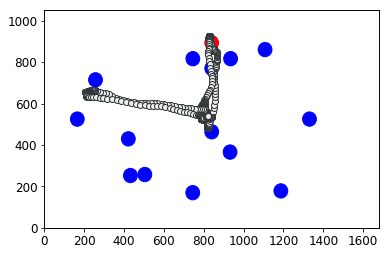

deviation from center is -15.90 pixels


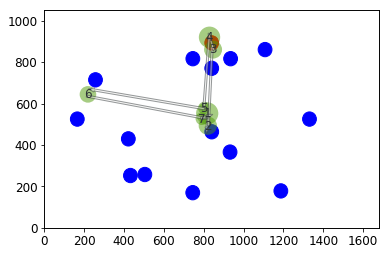

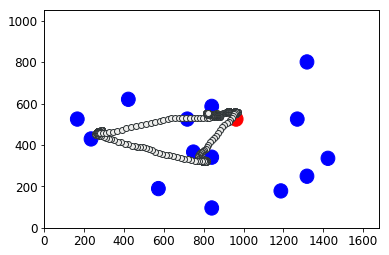

deviation from center is -16.30 pixels


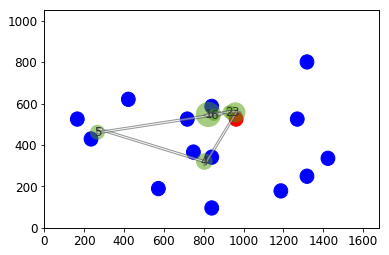

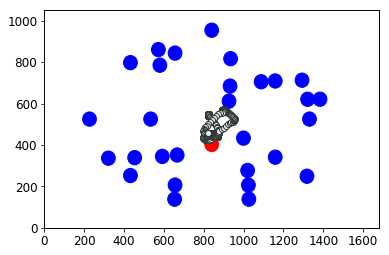

deviation from center is -9.50 pixels


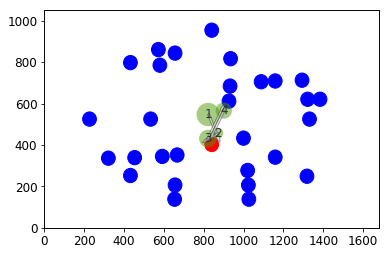

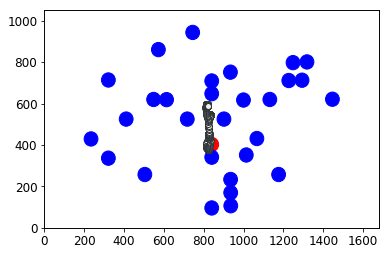

deviation from center is -12.90 pixels


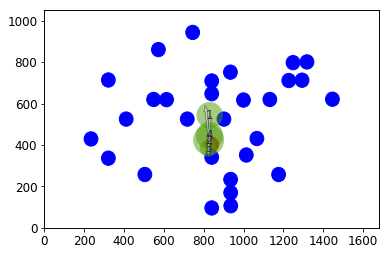

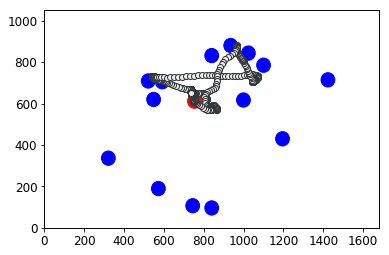

deviation from center is -8.60 pixels


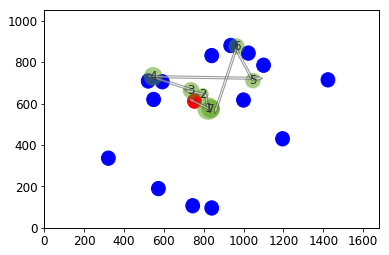

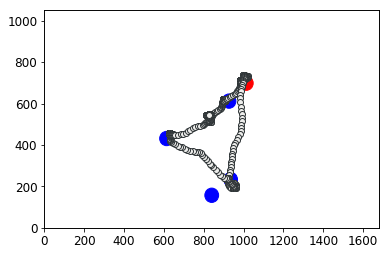

deviation from center is -14.10 pixels


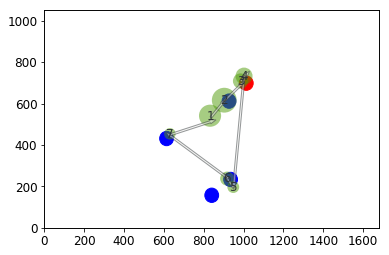

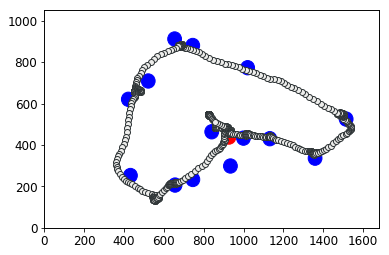

deviation from center is -17.80 pixels


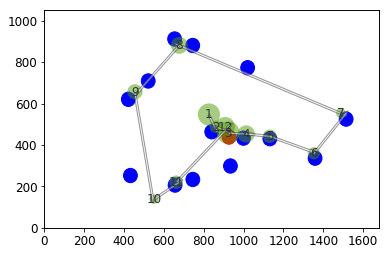

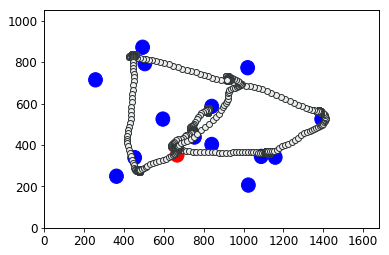

deviation from center is -25.00 pixels


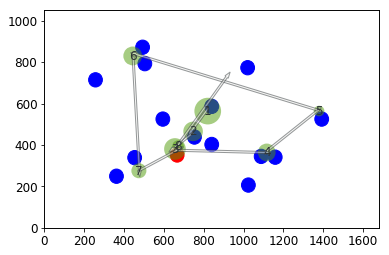

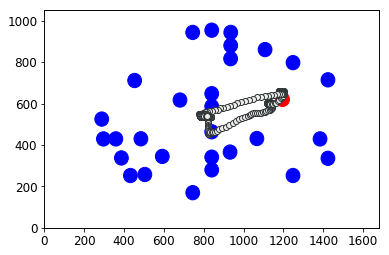

deviation from center is -27.80 pixels


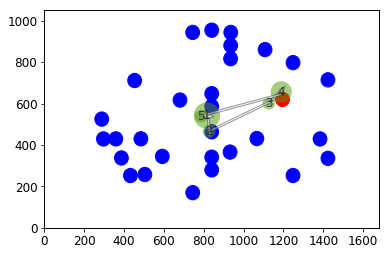

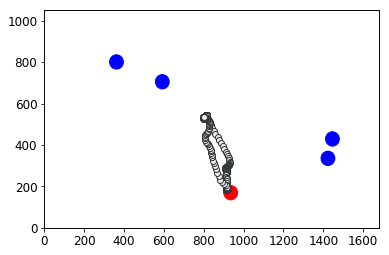

deviation from center is -18.40 pixels


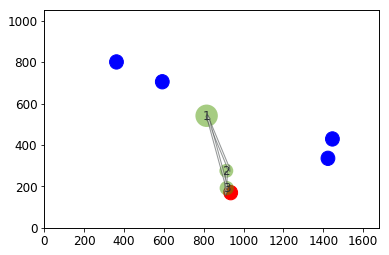

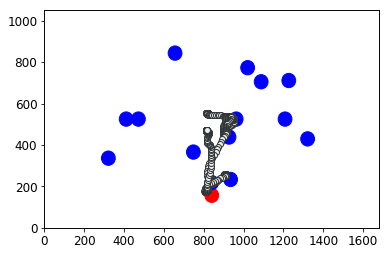

deviation from center is -32.70 pixels


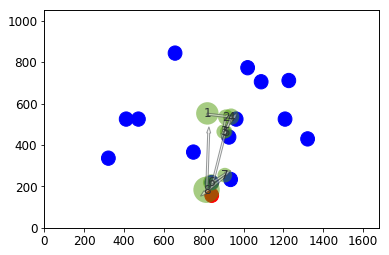

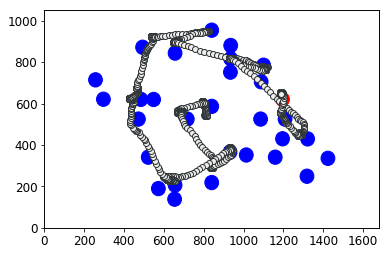

deviation from center is -23.40 pixels


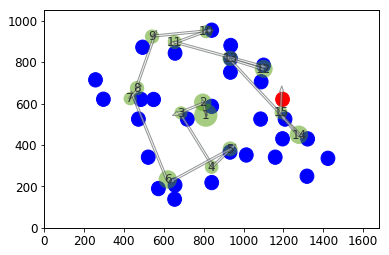

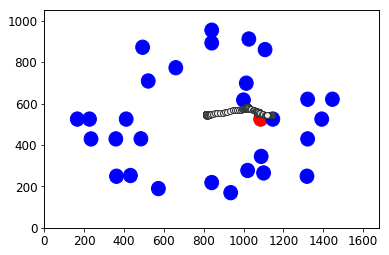

deviation from center is -18.00 pixels


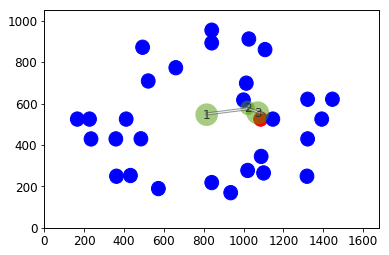

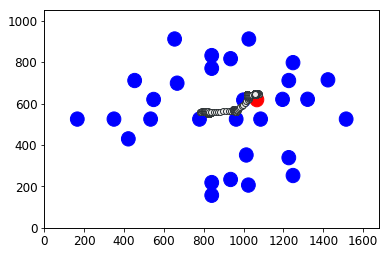

deviation from center is -0.40 pixels


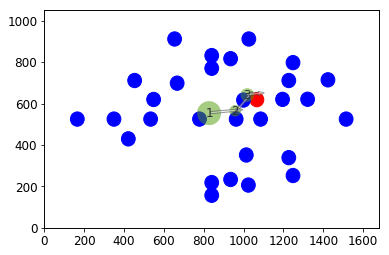

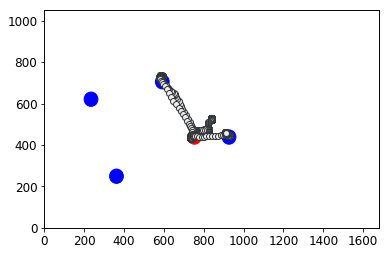

deviation from center is -30.20 pixels


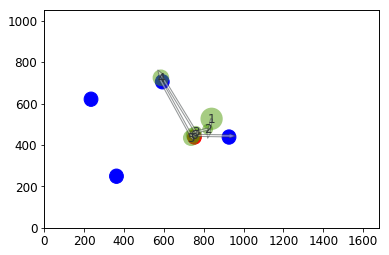

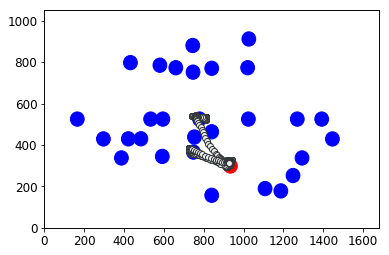

deviation from center is -33.80 pixels


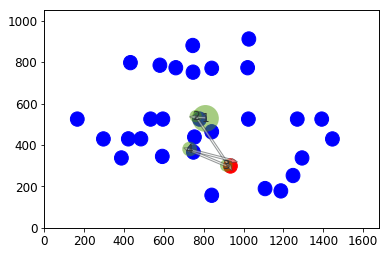

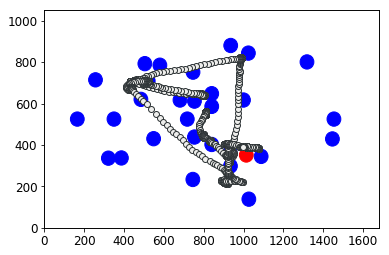

deviation from center is -21.80 pixels


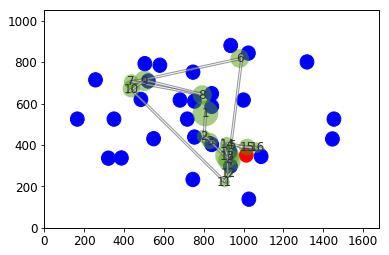

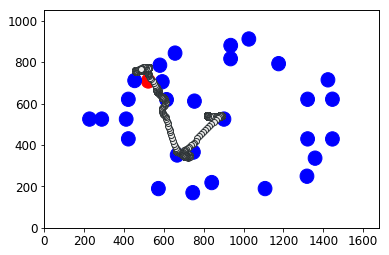

deviation from center is -20.50 pixels


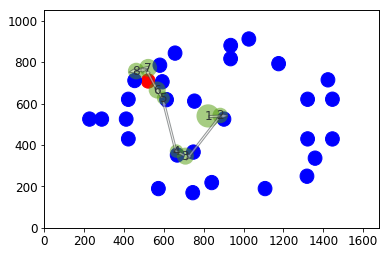

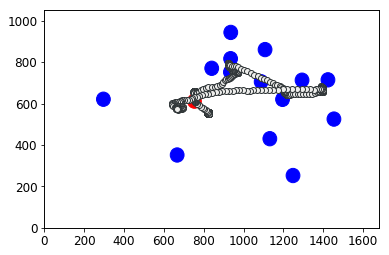

deviation from center is -18.80 pixels


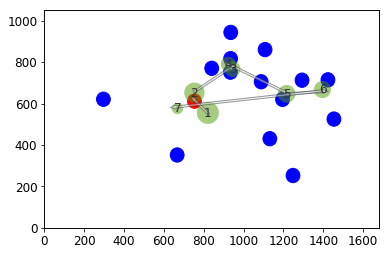

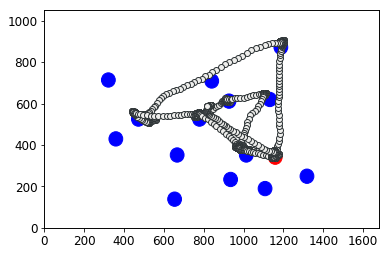

deviation from center is -13.30 pixels


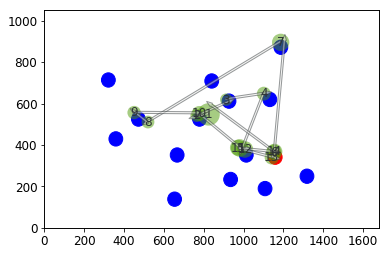

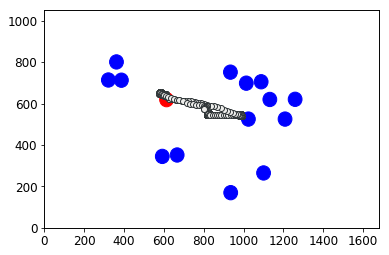

deviation from center is -12.00 pixels


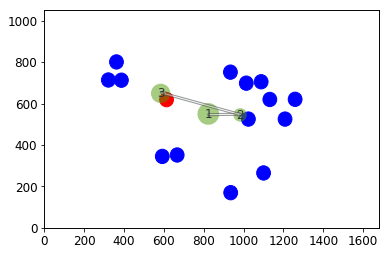

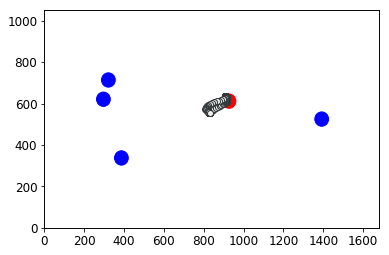

deviation from center is -0.40 pixels


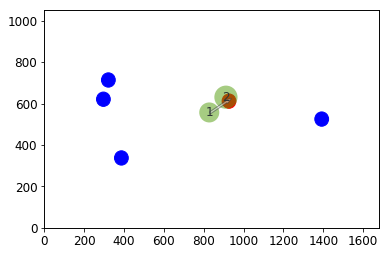

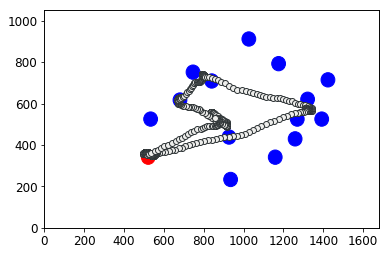

deviation from center is -14.20 pixels


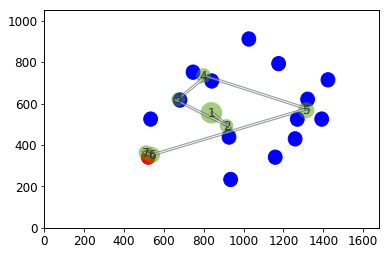

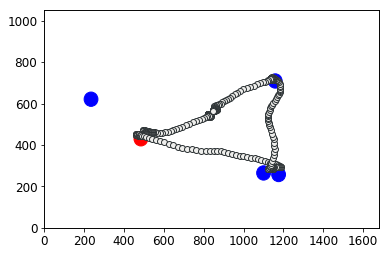

deviation from center is -0.10 pixels


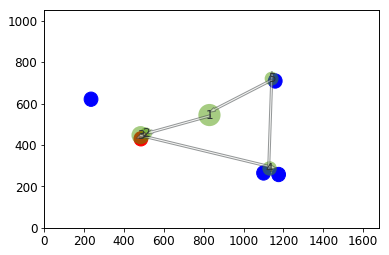

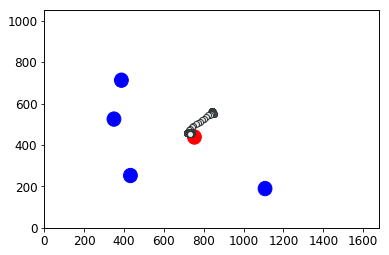

deviation from center is -10.30 pixels


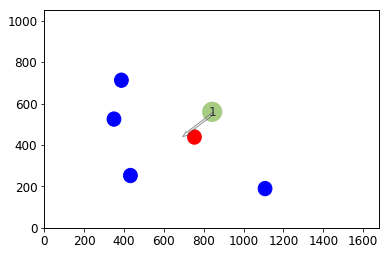

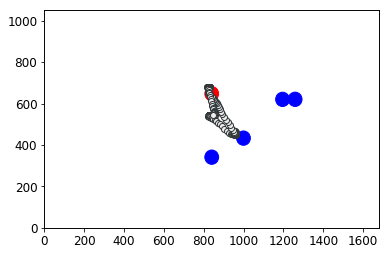

SystemError: <built-in method write of _io.BufferedWriter object at 0x11d6b5888> returned a result with an error set

In [9]:
# for all trials
for trial in range(len(edfdata)):
    
    # gaze data (x,y) for that trial
    gaze = np.array([edfdata[trial]['x'],edfdata[trial]['y']])
    print('deviation from center is %0.2f pixels' %float(gaze[0][0]-hRes/2))
    
    # weirdly arrays saved in data frame are turned to strings
    # this saves them as normal lists
    target_str = behv_data['target_position'][trial].replace(']','').replace('[','').split(' ')
    target_pos = [float(val) for i,val in enumerate(target_str) if len(val)>1]

    distr_srt = behv_data['distractor_position'][trial].replace(']','').replace('[','').replace(',','').split(' ')
    distr_pos = [float(val) for i,val in enumerate(distr_srt) if len(val)>1]
    
    # convert position coordinates to have 0,0 not centered in middle
    # so it's the same as gaze data (left corner centered)
    target_pos = [target_pos[0]+hRes/2,target_pos[1]+vRes/2]
    # also set pairs of distractor positions in same array, to make it easier to use
    alldistr_pos = [distr_pos[i*2:(i+1)*2] for i in range((len(distr_pos))//2)] 
    alldistr_pos = [[alldistr_pos[i][0]+hRes/2,alldistr_pos[i][1]+vRes/2] for i in range((len(distr_pos))//2)]
    
    # define saccades and fixations (defined by eyelink? or should I use different approach?)
    saccades = edfdata[trial]['events']['Esac'] 
    fixations = edfdata[trial]['events']['Efix'] 
    
    # actually draw them and save image
    draw_rawdata_display(sj,trial,filename,target_pos,alldistr_pos,gaze,hRes,vRes,ang2pix(2.2,30,50,vRes)/2)

    # actually draw them and save image
    draw_scanpath_display(sj,trial,filename,target_pos,alldistr_pos,fixations,saccades,hRes,vRes,ang2pix(2.2,30,50,vRes)/2)

    

In [ ]:
# IGNORE LOWER STUFF, LEFTOVERS THAT MIGHT BE USEFUL IN FUTURE

In [85]:
# COLOURS
# all colours are from the Tango colourmap, see:
# http://tango.freedesktop.org/Tango_Icon_Theme_Guidelines#Color_Palette
COLS = {	"butter": [	'#fce94f',
					'#edd400',
					'#c4a000'],
		"orange": [	'#fcaf3e',
					'#f57900',
					'#ce5c00'],
		"chocolate": [	'#e9b96e',
					'#c17d11',
					'#8f5902'],
		"chameleon": [	'#8ae234',
					'#73d216',
					'#4e9a06'],
		"skyblue": [	'#729fcf',
					'#3465a4',
					'#204a87'],
		"plum": 	[	'#ad7fa8',
					'#75507b',
					'#5c3566'],
		"scarletred":[	'#ef2929',
					'#cc0000',
					'#a40000'],
		"aluminium": [	'#eeeeec',
					'#d3d7cf',
					'#babdb6',
					'#888a85',
					'#555753',
					'#2e3436'],
		}

In [76]:
behv_data

,Unnamed: 0,RT,distractor_position,key_pressed,target_orientation,target_position
0,0,1.434572,"[[-453.21938072657764, 187.72961422728383], [9...",left,355,[ 7.50955136e-15 1.22640281e+02]
1,1,2.007401,"[[490.5611227197966, 0.0], [7.509551359061635e...",right,5,[-355.38424336 -95.22492101]
2,2,2.416504,"[[91.98021050996172, -159.31439789413483], [61...",left,355,[ 93.86480711 226.60969036]
3,3,0.751429,"[[346.8790964616543, 346.8790964616542], [-306...",right,5,[-86.71977412 86.71977412]
4,4,1.552271,"[[-407.8866665185306, 272.54115725979506], [1....",right,5,[ 86.71977412 -86.71977412]
5,5,0.897364,"[[346.87909646165417, -346.87909646165434], [2...",left,355,[ -2.25286541e-14 -1.22640281e+02]
6,6,2.190966,"[[267.6273750536434, 335.5941135900497], [86.7...",right,5,[ 226.60969036 -93.86480711]
7,7,1.230268,"[[-180.2153708017091, -248.04517816248094], [3...",right,355,[ -1.22640281e+02 1.50191027e-14]
8,8,1.681655,"[[-260.15932234624086, -260.1593223462406], [9...",left,355,[ 367.92084204 0. ]
9,9,10.853110,"[[429.240982379822, 0.0], [-91.98021050996181,...",left,355,[ 367.92084204 0. ]


Text(0.5,1,'gaze path')

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


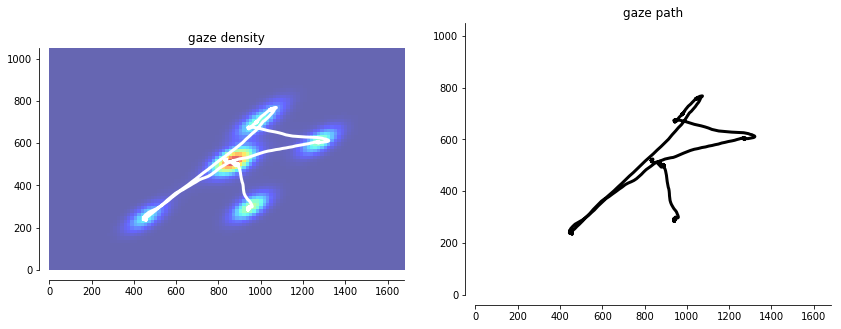

In [138]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn


f = plt.figure(figsize = (14,5))
s = f.add_subplot(121)
plt.plot(gaze[0], gaze[1])
s.set_xlim([0,hRes])
s.set_ylim([0,vRes])
sn.despine(ax=s, offset=10)
plt.imshow(density.reshape(x_pixels.shape)[::-1,:], alpha=0.6, extent=[0,hRes,0,vRes], cmap='jet')
plt.plot(gaze[0], gaze[1], 'w', lw=3)
s.set_title('gaze density')

s = f.add_subplot(122)
#plt.imshow(254-image.squeeze()[::-1,::-1], alpha=0.75, clim=[0,512])
plt.plot(gaze[0], gaze[1],'k', lw=3)
s.set_xlim([0,hRes])
s.set_ylim([0,vRes])
sn.despine(ax=s, offset=10)
s.set_title('gaze path')

In [104]:
##plot
#from pygazeanalyser.gazeplotter import draw_fixations, draw_heatmap, draw_scanpath, draw_raw

#rawplotfile = os.path.join(os.path.split(filename)[0], "raw_data_%s_%d" % (sj,trial))
#draw_raw(gaze[0], gaze[1], (hRes,vRes), savefilename=rawplotfile)

In [135]:
## scanpath
#saccades = edfdata[trial]['events']['Esac'] # [starttime, endtime, duration, startx, starty, endx, endy]
#fixations = edfdata[trial]['events']['Efix'] # [starttime, endtime, duration, endx, endy]

#scanpathfile =  os.path.join(os.path.split(filename)[0], "scanpath_%s_%d" % (sj,trial))
#draw_scanpath(fixations, saccades, (hRes,vRes), alpha=0.5, savefilename=scanpathfile)